In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.units import Unit as u
from copy import copy, deepcopy

from kl_tools.kross.data import get_kross_obj_data
from kl_tools.kross.cube import KROSSDataCube
from kl_tools.kross.tfr import estimate_vtf
from kl_tools.velocity import VelocityMap
from kl_tools.intensity import IntensityMapFitter
from kl_tools.coordinates import OrientedAngle
from kl_tools.basis import build_basis
from kl_tools.utils import add_colorbar, build_map_grid

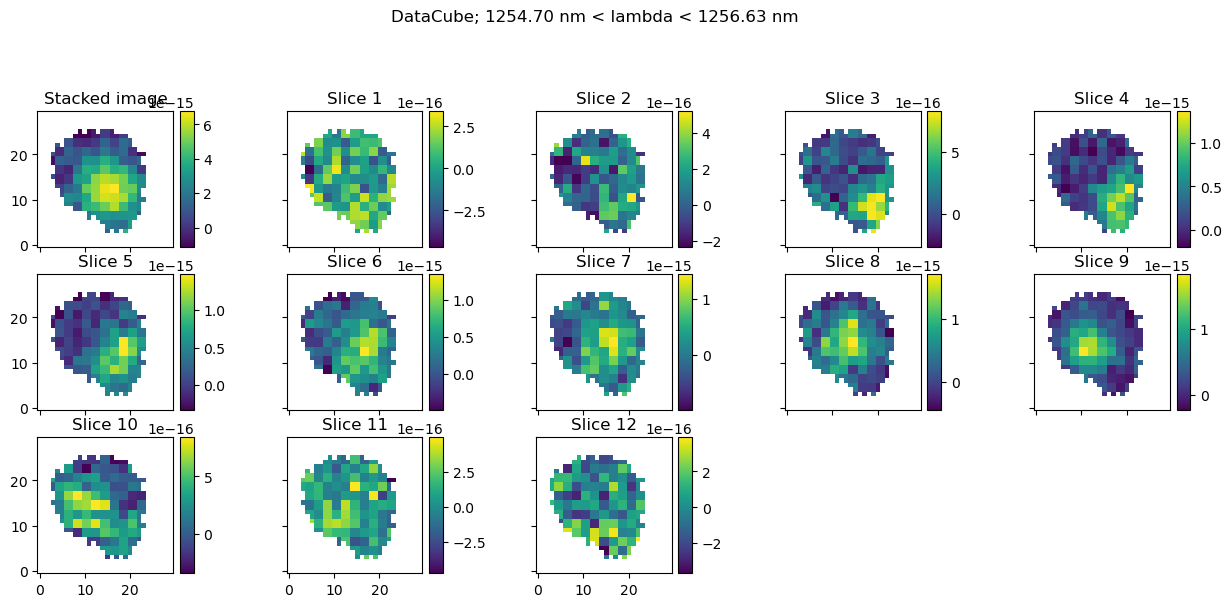

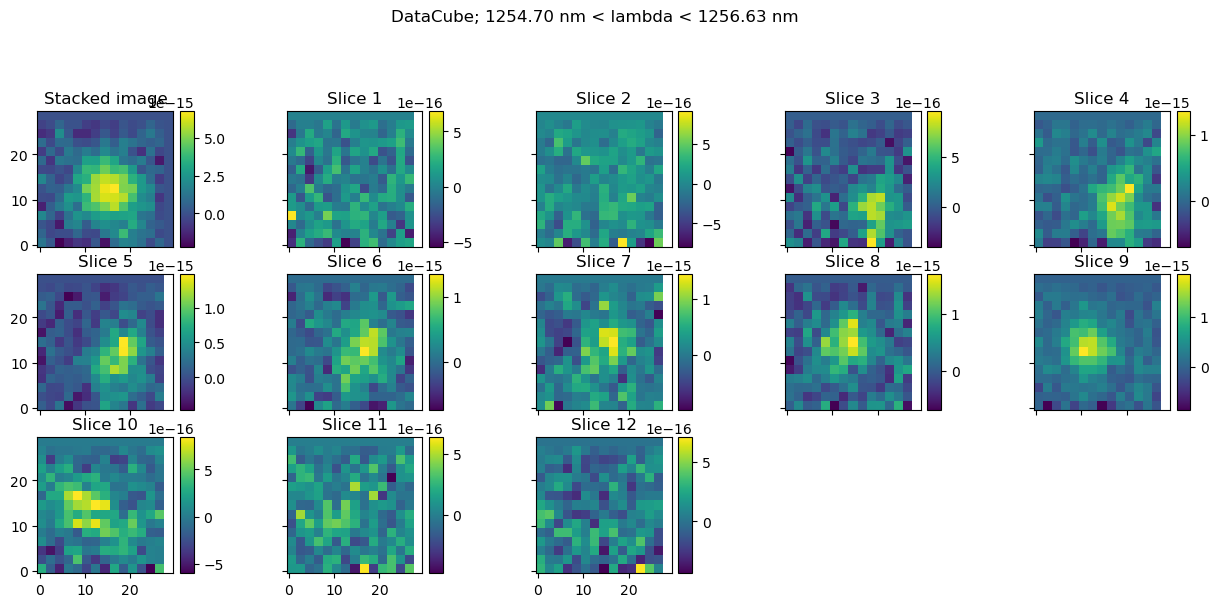

10h00m56.2704s +02d18m41.01912s


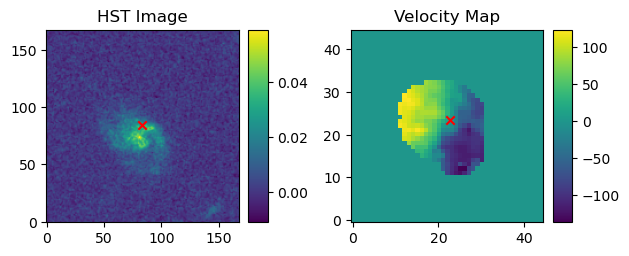

In [2]:
# global settings
plot = True

kid = 171
cube = KROSSDataCube(kid)

# truncate to the Halpha line
cube.set_line('Ha')

# might be helpful later on
obj_data = get_kross_obj_data(kid)

image = obj_data['hst']
image_wcs = WCS(obj_data['hst_hdr'])
vmap = obj_data['velocity']
vmap_wcs = WCS(obj_data['velocity_hdr'])

if plot is True:
    # mask on
    cube.plot(show=True, mask=True, max_cols=5)
    # mask off
    cube.plot(show=True, mask=False, max_cols=5)

    # get the center of the obj
    row = obj_data['catalog']
    ra = row['RA'][0]
    dec = row['DEC'][0]
    coord = SkyCoord(ra, dec, unit='deg')
    print(coord.to_string('hmsdms'))

    image_center = image_wcs.world_to_pixel(coord)
    vmap_center = vmap_wcs.world_to_pixel(coord)

    plt.subplot(121)
    im = plt.imshow(image, origin='lower')
    add_colorbar(im)
    plt.scatter(*image_center, marker='x', color='r')
    plt.title('HST Image')

    plt.subplot(122)
    im = plt.imshow(vmap, origin='lower')
    add_colorbar(im)
    plt.scatter(*vmap_center, marker='x', color='r')
    plt.title('Velocity Map')

    # plt.suptitle(f'KID {kid} Data Vector')
    plt.tight_layout()
    plt.show()

    # One at at time, with WCS projection
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection=image_wcs)
    # im = ax.imshow(image, origin='lower')
    # ax.scatter(*image_center, marker='x', color='r')
    # # add_colorbar(im)
    # ax.set_title('HST Image')
    # fig.set_size_inches(4, 4)
    # plt.show()

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection=vmap_wcs)
    # im = ax.imshow(vmap, origin='lower')
    # # add_colorbar(im)
    # ax.scatter(*vmap_center, marker='x', color='r')
    # ax.set_title('Velocity Map')
    # fig.set_size_inches(4, 4)
    # plt.show()

### New 2x2D datavector

Vmap pixel scale: 0.10000008
image pixel scale: 0.029999998800000004
---------
vtf: 140.57
vlow: 63.32
vhigh: 396.37
---------
sini: 0.80
sini_low: 0.60
sini_high: 1.00
---------
Optimization success: True
Optimized parameters: [ 0.00000000e+00  1.11910497e+02  3.00000240e-01  7.96105335e-01
  1.18682389e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+01 -1.58302989e-09 -1.58302989e-09
  2.04033091e-01]
{'v0': 0.0, 'vcirc': 111.91049655408737, 'rscale': 0.30000024000000003, 'sini': 0.7961053348470382, 'theta_int': 1.1868238913561442, 'g1': 0.0, 'g2': 0.0, 'vmap_x0': 0.0, 'vmap_y0': 0.0, 'r_unit': Unit("arcsec"), 'v_unit': Unit("km / s")}
{'beta': 10.0, 'image_x0': -1.5830298854460806e-09, 'image_y0': -1.5830298854460806e-09, 'basis': array([0.20403309])}


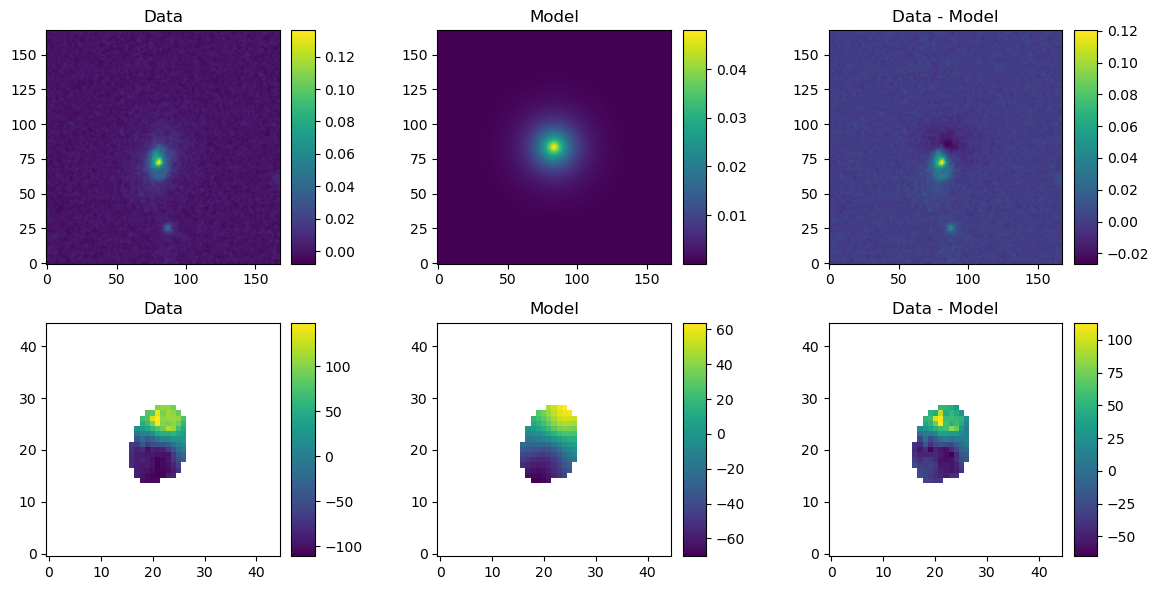

In [ ]:
def theta2pars(theta, r_unit=u('arcsec'), v_unit=u('km/s'), pars_type='both'):
    '''
    Map a fixed array of parameters to a dict of vmap parameters.

    We have more general tools to handle this, but this is a simple
    way to handle the fixed parameters in the KROSS model.
    '''

    vmap_pars = {
        'v0': theta[0],
        'vcirc': theta[1],
        'rscale': theta[2],
        'sini': theta[3],
        'theta_int': theta[4],
        'g1': theta[5],
        'g2': theta[6],
        'vmap_x0': theta[7],
        'vmap_y0': theta[8],
        'r_unit': r_unit,
        'v_unit': v_unit,
    }

    basis_pars = {
        'beta': theta[9],
        'image_x0': theta[10],
        'image_y0': theta[11],
        'basis': theta[12:] # arbitrary number of basis coefficients
    }

    if pars_type == 'vmap':
        pars = vmap_pars
    elif pars_type == 'basis':
        pars = basis_pars
    else:
        pars = {**vmap_pars, **basis_pars}

    return pars

def pars2theta(pars):
    '''
    Map a dict of vmap parameters to a fixed array of parameters for the fitter

    We have more general tools to handle this, but this is a simple
    way to handle the fixed parameters in the KROSS model.
    '''

    theta_pars = [
        pars['v0'],
        pars['vcirc'],
        pars['rscale'],
        pars['sini'],
        pars['theta_int'],
        pars['g1'],
        pars['g2'],
        pars['vmap_x0'],
        pars['vmap_y0'],
    ]

    theta_basis = [
        pars['beta'],
        pars['image_x0'],
        pars['image_y0'],
        pars['basis']
    ]

    return np.array(theta_pars + theta_basis)

def make_model_image(theta, image_data):
    image = image_data[0]
    image_wcs = image_data[3]
    shape = image.shape
    Nrow, Ncol = shape
    Nx, Ny = Ncol, Nrow
    X, Y = build_map_grid(Nx, Ny, indexing='xy')

    # get the model pars
    pars_vmap = theta2pars(theta, pars_type='vmap')
    pars_basis = theta2pars(theta, pars_type='basis')

    # get the pixel scale of the image
    cd_matrix = image_wcs.pixel_scale_matrix
    pixel_scales = np.sqrt((cd_matrix**2).sum(axis=0))
    pixel_scale = np.mean(pixel_scales) # only works for square pixels for now

    # setup the basis
    basis_type = 'exp_shapelets'
    Nbasis = len(pars_basis['basis'])
    Nmax = np.sqrt(Nbasis)
    if Nmax % 1 != 0:
        raise ValueError(
            'Number of basis functions must be a perfect square, for a polar ' 
            f'basis; {Nbasis} were passed'
            )
    Nmax = int(Nmax)
    try:
        beta = pars_basis['beta']
    except KeyError:
        print('No beta provided; letting basis set default')
        beta = None
    basis_kwargs = {
        'nx': Nx,
        'ny': Ny,
        'pix_scale': pixel_scale,
        'Nmax': Nmax,
        'beta': beta,
        'plane': plane,
        # TODO: add PSF when ready
        # 'psf': gs.Gaussian(...)
    }
    basis = build_basis(basis_type, basis_kwargs)

    # NOTE: we need to do some hacky business here to use the typical vmap 
    # transformation parameters for the basis functions, but with a *different*
    # set of offset parameters
    transformation_pars = pars_vmap.copy()
    transformation_pars['x0'] = pars_basis['image_x0']
    transformation_pars['y0'] = pars_basis['image_y0']
    del transformation_pars['vmap_x0']
    del transformation_pars['vmap_y0']

    # make the model image
    # basis_coefficients = theta_basis[3:] # fist 3 pars are beta and offset
    basis_coefficients = pars_basis['basis']
    model_image = basis.render_im(pars_vmap, basis_coefficients)

    # TODO: Add smooth, sersic disk model
    # disk = ...

    if debug is True:
        plt.subplot(131)
        im = plt.imshow(model_image, origin='lower')
        add_colorbar(im)
        plt.title('Model')
        plt.subplot(132)
        im = plt.imshow(image, origin='lower')
        add_colorbar(im)
        plt.title('HST Image')
        plt.subplot(133)
        im = plt.imshow(image - model_image, origin='lower')
        add_colorbar(im)
        plt.title('Data - Model')
        plt.gcf().set_size_inches(16, 4)
        plt.show()

    return model_image

def make_model_vmap(theta, vmap_data):
    vmap = vmap_data[0]
    vmap_wcs = vmap_data[3]

    # get the pixel scale of the velocity map
    cd_matrix = vmap_wcs.pixel_scale_matrix
    pixel_scales = np.sqrt((cd_matrix**2).sum(axis=0))
    pixel_scale = 3600*np.mean(pixel_scales)

    # NOTE: have to do some hacky business to allow for different offsets
    # between the vmap and the iamge
    vmap_pars = theta2pars(theta, pars_type='vmap')
    vmap_pars['x0'] = vmap_pars['vmap_x0']
    vmap_pars['y0'] = vmap_pars['vmap_y0']
    del vmap_pars['vmap_x0']
    del vmap_pars['vmap_y0']
    model_vmap = VelocityMap('offset', vmap_pars)

    Nrow, Ncol = vmap.shape
    Nx, Ny = Ncol, Nrow
    X, Y = build_map_grid(Nx, Ny, indexing='xy')

    model_vmap_sampled = model_vmap(
        'obs', X, Y, pix_scale=pixel_scale
        )

    if debug is True:
        plt.subplot(131)
        im = plt.imshow(model_vmap_sampled, origin='lower')
        add_colorbar(im)
        plt.title('Model')
        plt.subplot(132)
        im = plt.imshow(vmap, origin='lower')
        add_colorbar(im)
        plt.title('Data')
        plt.subplot(133)
        im = plt.imshow(vmap - model_vmap_sampled, origin='lower')
        add_colorbar(im)
        plt.title('Data - Model')
        plt.gcf().set_size_inches(16, 4)
        plt.show()

    return model_vmap_sampled

def compute_model(theta, datavector):
    image_data = datavector[0]
    vmap_data = datavector[1]

    model_image = make_model_image(theta, image_data)
    model_vmap = make_model_vmap(theta, vmap_data)

    return model_image, model_vmap

def compute_residuals(datavector, model):
    image_tuple = datavector[0]
    vmap_tuple = datavector[1]

    image = image_tuple[0]
    image_weights = image_tuple[1]
    image_mask = image_tuple[2]
    vmap = vmap_tuple[0]
    vmap_weights = vmap_tuple[1]
    vmap_mask = vmap_tuple[2]

    # reshape data
    image = image.ravel()
    image_weights = image_weights.ravel()
    image_mask = image_mask.ravel()
    vmap = vmap.ravel()
    vmap_weights = vmap_weights.ravel()
    vmap_mask = vmap_mask.ravel()

    model_image = model[0].ravel()
    model_vmap = model[1].ravel()

    image_residuals = (image - model_image) * image_weights * (~image_mask)
    vmap_residuals = (vmap - model_vmap) * vmap_weights * (~vmap_mask)

    return (image_residuals, vmap_residuals)

def log_objective(theta, datavector, l1_indices=None, l1_lambda=1.):
    model = compute_model(theta, datavector)
    residuals = compute_residuals(datavector, model)

    # TODO: TESTING ONLY
    # [0] are the image residuals, [1] are the vmap residuals
    # chi2 = np.sum(residuals[0]**2) + np.sum(residuals[1]**2)
    chi2 = np.sum(residuals[0]**2)

    if l1_indices is None:
        l1_norm = 0
    else:
        l1_norm = l1_lambda * np.sum(np.abs(theta[l1_indices]))

    return 0.5 * chi2 + l1_norm

#-------------------------------------------------------------------------------
# Test the objective function

# START HERE

plot = True
debug = False # extra plots for debugging
vb = True
plane = 'cen'
# plane = 'obs' # plane of the basis functions. Typicaly 'obs' or 'disk'

# kid = 171
# kid = 20
# kid = 11 # compact and offset
kid = 116 # spiral arms with shape; offset

obj_data = get_kross_obj_data(kid)
row = obj_data['catalog']

image = obj_data['hst']
vmap = obj_data['velocity']

image_wcs = WCS(obj_data['hst_hdr'])
vmap_wcs = WCS(obj_data['velocity_hdr'])

vmap_pixel_scale_mat = vmap_wcs.pixel_scale_matrix
vmap_pixel_scale = 3600*np.sqrt(
    (vmap_pixel_scale_mat**2).sum(axis=0)
    ).mean() # arcsec
print(f'Vmap pixel scale: {vmap_pixel_scale}')

image_pixel_scale_mat = image_wcs.pixel_scale_matrix
image_pixel_scale = 3600*np.sqrt(
    (image_pixel_scale_mat**2).sum(axis=0)
    ).mean() # arcsec
print(f'image pixel scale: {image_pixel_scale}')

datavector = [image, vmap]

basis_Nmax = 1
Nbasis_coeff = basis_Nmax**2 # for a polar basis
Nbasis = Nbasis_coeff + 3 # add a scale factor & offset to scan over
Nvmap = 9 # fixed for an offset vmap model
Ntheta = Nvmap + Nbasis
basis_indices = np.arange(Nvmap+1, Ntheta, 1)
theta_vmap = np.random.rand(Nvmap)
theta_basis = np.random.random(Nbasis)
theta = np.concatenate((theta_vmap, theta_basis))

image_weights = np.ones_like(image)
image_mask = np.zeros_like(image, dtype=bool)
vmap_weights = np.ones_like(vmap)
vmap_mask = np.zeros_like(vmap, dtype=bool)
vmap_mask[vmap == 0] = 1
vmap_weights[vmap_mask] = 0
datavector = [
    (image, image_weights, image_mask, image_wcs),
    (vmap, vmap_weights, vmap_mask, vmap_wcs),
    ]

#-------------------------------------------------------------------------------
# get sensible initial values for the vmap parameters

vel_pa = row['VEL_PA'][0] # position angle of the measured vmap
theta_im = row['THETA_IM'][0] # inclination angle of the galaxy
# v22_obs = row['V22_OBS'][0] # observed velocity at 2.2 x Rd
mstar = row['MASS'][0]

# derived from KROSS
log_mstar = np.log10(mstar)
sini_kross = np.sin(np.deg2rad(theta_im))

# we'll use the KROSS PA to set the initial guess for theta_int
vel_pa = OrientedAngle(vel_pa, unit='deg', orientation='east-of-north')

vtf, v_bounds = estimate_vtf(log_mstar, return_error_bounds=True)
vlow, vhigh = vtf - v_bounds[0], vtf + v_bounds[1]

sig_vtf = 1
vtf_scatter_dex = sig_vtf * 0.05
vtf_fator = 10**vtf_scatter_dex
vcirc_base = vtf * sini_kross
vcirc_low = vcirc_base / vtf_fator
vcirc_high = vcirc_base * vtf_fator

sini_low = 0.75 * sini_kross
sini_high = 1.25 * sini_kross
sini_low = max(0, sini_low)
sini_high = min(1, sini_high)

if vb is True:
    print('---------')
    print(f'vtf: {vtf:.2f}')
    print(f'vlow: {vlow:.2f}')
    print(f'vhigh: {vhigh:.2f}')
    print('---------')
    print(f'sini: {sini_kross:.2f}')
    print(f'sini_low: {sini_low:.2f}')
    print(f'sini_high: {sini_high:.2f}')
    print('---------')

# set bounds & initial values
# pars['v0'],
# pars['vcirc'],
# pars['rscale'],
# pars['sini'],
# pars['theta_int'],
# pars['g1'],
# pars['g2'],
# pars['x0'],
# pars['y0'],
base_bounds = [
    (-10, 10), # v0
    (vcirc_low, vcirc_high), # vcirc
    (1.5*vmap_pixel_scale, 10), # rscale; KROSS pixels
    (sini_low, sini_high), # sini
    (0, 2*np.pi), # theta_int
    (-.0001, .0001), # g1
    (-.0001, .0001), # g2
    (-15, 15), # vmap x0
    (-15, 15), # vmap y0
    (3, 10), # beta; HST pixels
    (-10, 10), # HST pixel offset
    (-10, 10), # HST pixel offset
    ]

# initial guess for the optimizer
base_initial_theta = [
    0.0, # v0
    vcirc_base, # vcirc
    3*vmap_pixel_scale, # rscale; KROSS pixels
    sini_kross, # sini
    vel_pa.cartesian.rad, # theta_int
    0.0, # g1
    0.0, # g2
    0.0, # vmap x0
    0.0, # vmap y0
    5*image_pixel_scale, # beta; HST pixels
    -50.0, # HST pixel offset
    -50.0, # HST pixel offset
    ]

# combine with unconstrained basis coefficients
bounds = list(
    base_bounds + [(None, None)] * (Ntheta - len(base_bounds))
)

# Ensure initial theta values are within the bounds
initial_theta = np.array([
    base_initial_theta[i] if (i < Nvmap+3) else np.random.rand() for i in range(Ntheta)
])

# for i, init in enumerate(initial_theta):
#     low, high = bounds[i]
#     if (low is not None) and (high is not None):
#         if init < low or init > high:
#             initial_theta[i] = np.random.uniform(low, high)
#     else:
#         continue

result = minimize(
    log_objective,
    initial_theta,
    args=(datavector, basis_indices, 1e-1),
    method='L-BFGS-B',
    bounds=bounds
)

optimized_theta = result.x

print("Optimization success:", result.success)
print("Optimized parameters:", optimized_theta)
print(theta2pars(optimized_theta, pars_type='vmap'))
print(theta2pars(optimized_theta, pars_type='basis'))
nts = optimized_theta[basis_indices]
opt_image = make_model_image(optimized_theta, datavector[0])
opt_vmap = make_model_vmap(optimized_theta, datavector[1])

# apply the same masks
image_mask = copy(datavector[0][2])
vmap_mask = copy(datavector[1][2])

image[image_mask] = np.nan
vmap[vmap_mask] = np.nan
opt_image[image_mask] = np.nan
opt_vmap[vmap_mask] = np.nan

plt.subplot(231)
im = plt.imshow(image, origin='lower')
add_colorbar(im)
plt.title('Data')
plt.subplot(232)
im = plt.imshow(opt_image, origin='lower')
add_colorbar(im)
plt.title('Model')
plt.subplot(233)
im = plt.imshow(image - opt_image, origin='lower')
add_colorbar(im)
plt.title('Data - Model')
plt.subplot(234)
im = plt.imshow(vmap, origin='lower')
plt.title('Data')
add_colorbar(im)
plt.subplot(235)
im = plt.imshow(opt_vmap, origin='lower')
add_colorbar(im)
plt.title('Model')
plt.subplot(236)
im = plt.imshow(vmap - opt_vmap, origin='lower')
add_colorbar(im)
plt.title('Data - Model')

plt.gcf().set_size_inches(12, 6)
plt.tight_layout()
plt.show()


(-10, 10): 0.0
(96.6384088562669, 121.66054866450888): 108.43007813110975
(0.15000012000000001, 10): 0.30000024000000003
(0.6592853748361518, 1): 0.8790471664482025
(0, 6.283185307179586): 0.24434609527920614
(-0.0001, 0.0001): 0.0
(-0.0001, 0.0001): 0.0
(-15, 15): 0.0
(-15, 15): 0.0
(3, 10): 0.14999999400000003
(-10, 10): -50.0
(-10, 10): -50.0
(None, None): 0.12674603976971743


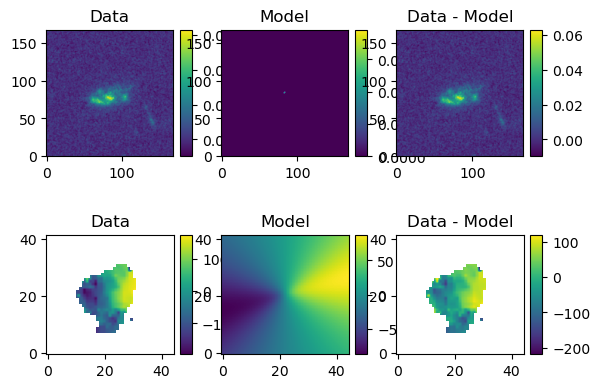

In [49]:
initial_theta
initial_image = make_model_image(initial_theta, datavector[0])
initial_vmap = make_model_vmap(initial_theta, datavector[1])

for i in range(len(initial_theta)):
    print(f'{bounds[i]}: {initial_theta[i]}')

plt.subplot(231)
im = plt.imshow(image, origin='lower')
add_colorbar(im)
plt.title('Data')
plt.subplot(232)
im = plt.imshow(initial_image, origin='lower')
add_colorbar(im)
plt.title('Model')
plt.subplot(233)
im = plt.imshow(image - initial_image, origin='lower')
add_colorbar(im)
plt.title('Data - Model')
plt.subplot(234)
im = plt.imshow(vmap, origin='lower')
plt.title('Data')
add_colorbar(im)
plt.subplot(235)
im = plt.imshow(initial_vmap, origin='lower')
add_colorbar(im)
plt.title('Model')
plt.subplot(236)
im = plt.imshow(vmap - initial_vmap, origin='lower')
add_colorbar(im)
plt.title('Data - Model')
plt.show()

In [33]:
row['NAME'][0]

'C-HiZ_z1_245'

In [34]:
obj_data['hst_file']

'/Users/severett/repos/kl-tools/data/cosmos/cutouts/0010_150.25717_1.8642214_acs_I_mosaic_30mas_sci.fits'